# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [31]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [69]:
df = pd.read_csv('data/promice/preprocessed/daily/SCO_L.csv')

##### Pre-processing (0.1: Change months to cycle)

In [70]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [71]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df = df[df['Wind from direction (upper boom)'].notna()] 

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# without year
cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

##### Pre-processing (1.0: Filter relevant periods)

In [72]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('')

In [73]:
#Only Ablation Period Or Melting Season
#df = df[df['Ablation'] == True]
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#Remove all NA values if training should be done only on ablation
#df = df.dropna()

df = df.reset_index(drop=True)

In [74]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

##### Pre-processing (2.0: Formatting and transformation)

In [75]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['Melting Season'] = le.fit_transform(df['Melting Season'])
dict(zip(le.classes_, le.transform(le.classes_)))

{'': 0, 'beginning': 1, 'end': 2, 'middle': 3, 'pre': 4}

In [76]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                          # 'Melting Season', # We drop melting season later 
                                               'month','day', 'hour', # Drop because of sin & cos values
#                'year',
                                                                 'subgroup'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [77]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# with year
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year', 'Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

# without year
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [78]:
df = df[['Surface height from combined measurements','Surface height from combined measurements DELTA' ,'Melting Season' ,'year' ,'month_sin' ,'month_cos']]



In [79]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split the data into training and testing sets while maintaining the subgroup distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

### Delta ###
df_delta = df[[column for column in df.columns if column not in ["Surface height from combined measurements"]]]

for train_index, test_index in split.split(df_delta, df_delta['Melting Season']):
    delta_train = df_delta.loc[train_index]
    delta_test = df_delta.loc[test_index]

# separate the features and target variables for the train and test sets
X_delta_train = delta_train.drop(['Surface height from combined measurements DELTA', 'Melting Season'], axis=1)
y_delta_train = delta_train['Surface height from combined measurements DELTA']
X_delta_test = delta_test.drop(['Surface height from combined measurements DELTA', 'Melting Season'], axis=1)
y_delta_test = delta_test['Surface height from combined measurements DELTA']

### Absolute ###
df_absolute = df[[column for column in df.columns if column not in ["Surface height from combined measurements DELTA"]]]

for train_index, test_index in split.split(df_absolute, df_absolute['Melting Season']):
    absolute_train = df_absolute.loc[train_index]
    absolute_test = df_absolute.loc[test_index]

# separate the features and target variables for the train and test sets
X_absolute_train = absolute_train.drop(['Surface height from combined measurements', 'Melting Season'], axis=1)
y_absolute_train = absolute_train['Surface height from combined measurements']
X_absolute_test = absolute_test.drop(['Surface height from combined measurements', 'Melting Season'], axis=1)
y_absolute_test = absolute_test['Surface height from combined measurements']


## XGB Regression

In [80]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [81]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Define the XGBRegressor model
    #model = xgb.XGBRegressor()
    exec(f"model_{i} = xgb.XGBRegressor()")
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'max_depth': [7], #[3, 5, 7],
        'min_child_weight': [5], #[1, 3, 5],
        'learning_rate': [0.1], #[0.1, 0.01, 0.001],
        'n_estimators': [100], #[100, 500, 1000],
        'subsample': [0.5], #[0.5, 0.7, 1.0],
        'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
        'reg_alpha': [0.5], #[0, 0.1, 0.5],
        'reg_lambda': [0.1], #[0, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(eval(f"model_{i}"), param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search object to the training data
    grid_search.fit(X_train_category, y_train_category)
    
    # Print the best hyperparameters and the corresponding R^2 score on the test set
    print(f"Best hyperparameters_{i}: ", grid_search.best_params_)
    
    # Save the best model parameters as 'model' variable
    exec(f"model_{i} = grid_search.best_estimator_")
    
    # Evaluate the best model on the test set
    y_pred_category = eval(f"model_{i}").predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)

Best hyperparameters_delta:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (delta):  0.001959650979504568
MSE on test set (delta):  0.005178204288227521
Best hyperparameters_absolute:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (absolute):  0.9989869972432538
MSE on test set (absolute):  0.12347500793316861


In [82]:
# This bit to see output of the best delta model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_delta_test.index)
y_Test_valid_indices = indices.intersection(y_delta_test.index)

# filter out by indeces
X_test_category = X_delta_test.loc[X_Test_valid_indices]  
y_test_category = y_delta_test.loc[y_Test_valid_indices]

y_pred_category = model_delta.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.001959650979504568
MSE on test set:  0.005178204288227521


R^2 score on test set:  0.9880669458544213
MSE on test set:  1.3869122474196862
     Feature  Importance
0       year    0.962704
1  month_sin    0.035625
2  month_cos    0.001671


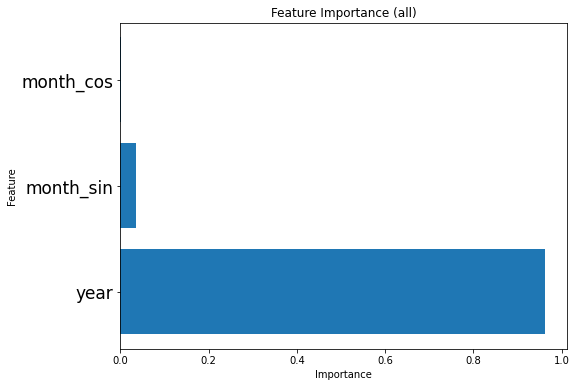

In [84]:
# This bit to see output of the best absolute model

indices = eval(f"indices_all")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_absolute_test.index)
y_Test_valid_indices = indices.intersection(y_absolute_test.index)

# filter out by indeces
X_test_category = X_absolute_test.loc[X_Test_valid_indices]  
y_test_category = y_absolute_test.loc[y_Test_valid_indices]

y_pred_category = model_absolute.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

# Get the feature importance scores and plot them
feature_importance = pd.DataFrame({'Feature': X_absolute_train.columns, 'Importance': model_absolute.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
print(feature_importance)
feature_importance = feature_importance.head(5)

# Plot the feature importance scores
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance (all)')
plt.yticks(fontsize=17)  
plt.show()

## Filter by Melting Season and get feature importances Fitting Seasons again

R^2 score on test set (pre):  -0.12116718189777465
MSE on test set (pre):  0.011283556524182671
     Feature  Importance
0       year    0.473149
1  month_sin    0.359544
2  month_cos    0.167306


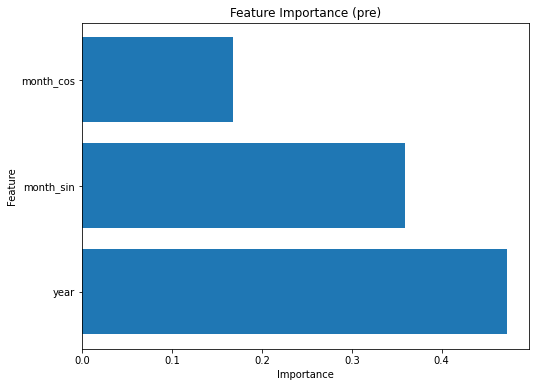

R^2 score on test set (beginning):  -0.027772601194115953
MSE on test set (beginning):  0.03167810674502264
     Feature  Importance
0       year    0.473149
1  month_sin    0.359544
2  month_cos    0.167306


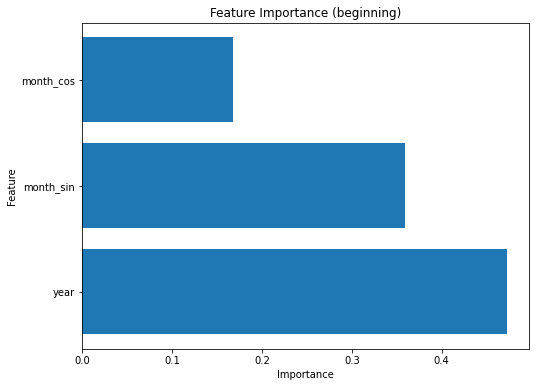

R^2 score on test set (middle):  0.13290959789210077
MSE on test set (middle):  0.0003341035627209038
     Feature  Importance
0       year    0.473149
1  month_sin    0.359544
2  month_cos    0.167306


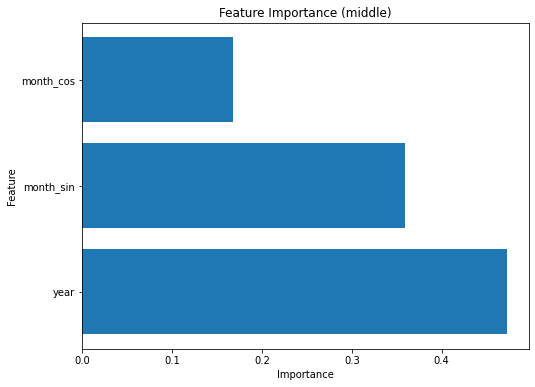

R^2 score on test set (end):  -0.1648879727553354
MSE on test set (end):  0.0027359772987951207
     Feature  Importance
0       year    0.473149
1  month_sin    0.359544
2  month_cos    0.167306


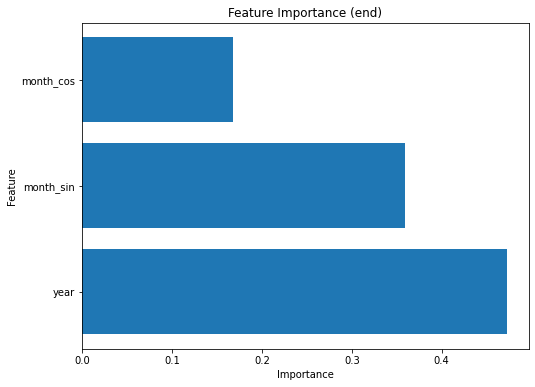

In [85]:
### This bit for delta
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_delta_train.index)
    y_Train_valid_indices = indices.intersection(y_delta_train.index)
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)

    # filter out by indeces
    X_train_category = X_delta_train.loc[X_Train_valid_indices]
    y_train_category = y_delta_train.loc[y_Train_valid_indices]
    X_test_category = X_delta_test.loc[X_Test_valid_indices]
    y_test_category = y_delta_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    #model_delta.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_delta.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


R^2 score on test set (pre):  0.992480800845072
MSE on test set (pre):  0.7952142872467193
     Feature  Importance
0       year    0.962704
1  month_sin    0.035625
2  month_cos    0.001671


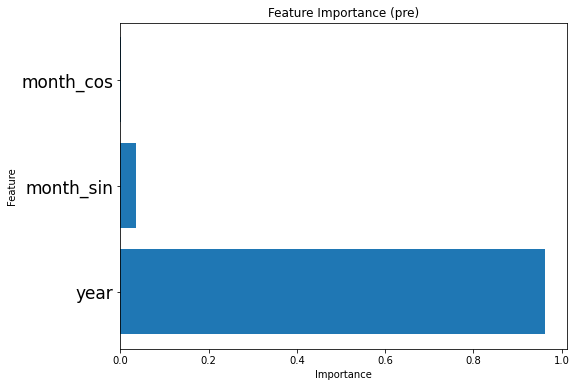

R^2 score on test set (beginning):  0.998109769306566
MSE on test set (beginning):  0.23200171466029135
     Feature  Importance
0       year    0.962704
1  month_sin    0.035625
2  month_cos    0.001671


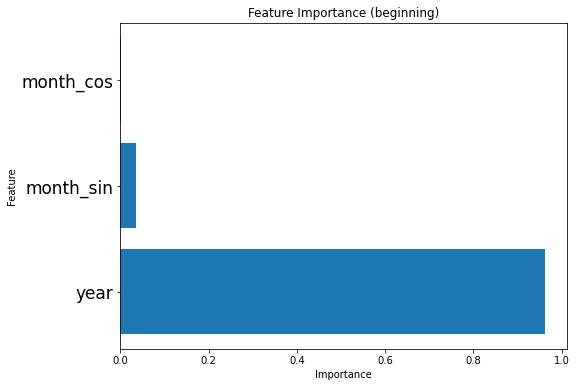

R^2 score on test set (middle):  0.9990618106021815
MSE on test set (middle):  0.11082417733506854
     Feature  Importance
0       year    0.962704
1  month_sin    0.035625
2  month_cos    0.001671


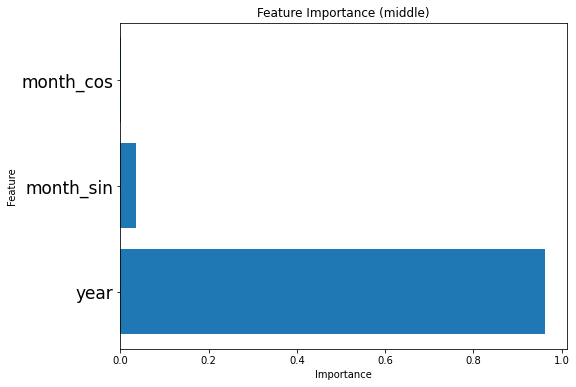

R^2 score on test set (end):  0.9994231368950501
MSE on test set (end):  0.0777758831208468
     Feature  Importance
0       year    0.962704
1  month_sin    0.035625
2  month_cos    0.001671


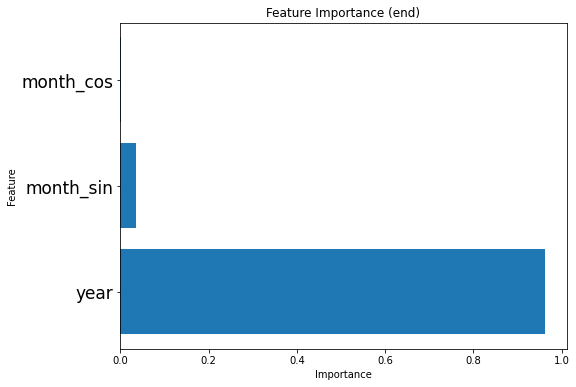

In [86]:
### This bit for absolute
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_absolute_train.index)
    y_Train_valid_indices = indices.intersection(y_absolute_train.index)
    X_Test_valid_indices = indices.intersection(X_absolute_test.index)
    y_Test_valid_indices = indices.intersection(y_absolute_test.index)

    # filter out by indeces
    X_train_category = X_absolute_train.loc[X_Train_valid_indices]
    y_train_category = y_absolute_train.loc[y_Train_valid_indices]
    X_test_category = X_absolute_test.loc[X_Test_valid_indices]
    y_test_category = y_absolute_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    #model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_absolute.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_absolute_train.columns, 'Importance': model_absolute.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)
    feature_importance = feature_importance.head(5)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.yticks(fontsize=17)  
    plt.show()


## Filter by Melting Season and get feature importances using SHAP

In [ ]:
import shap

In [ ]:
### This bit for delta
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_delta_train.index)
    y_Train_valid_indices = indices.intersection(y_delta_train.index)
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)

    # filter out by indeces
    X_train_category = X_delta_train.loc[X_Train_valid_indices]
    y_train_category = y_delta_train.loc[y_Train_valid_indices]
    X_test_category = X_delta_test.loc[X_Test_valid_indices]
    y_test_category = y_delta_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    #model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_delta.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)
    
    explainer = shap.TreeExplainer(model_delta)
    shap_values = explainer.shap_values(X_test_category, approximate=True)
    
    # Display top 5 features and SHAP values
    feature_importances = pd.Series(abs(shap_values).mean(0), index=X_test_category.columns)
    top_features = feature_importances.nlargest(5)
    shap_values_top = [shap_values[i] for i in np.where(feature_importances.index.isin(top_features.index))[0]]
    df_shap = pd.DataFrame(np.transpose(shap_values_top), columns=top_features.index)
    print(f"Top 5 important features for {category} period:")
    display(top_features)
    
    shap.summary_plot(shap_values, X_test_category, plot_type="bar", feature_names=X_test_category.columns, max_display=5, show=False)
    plt.title(f"Top 5 important features for {category} period")
    plt.show()


R^2 score on test set (pre):  -0.4007516507450277
MSE on test set (pre):  148.14047381985162
Top 5 important features for pre period:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Albedo                                         5.032064
Wind from direction (upper boom)_sin           3.231101
Downwelling shortwave radiation - corrected    2.305226
Surface temperature                            2.277392
Wind speed (upper boom)                        1.938527
dtype: float32

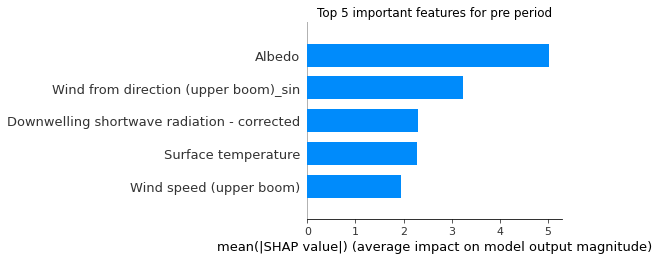

R^2 score on test set (beginning):  0.7638248964187837
MSE on test set (beginning):  28.987482417489076
Top 5 important features for beginning period:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Albedo                                  3.739708
Wind from direction (upper boom)_sin    3.099432
Surface temperature                     1.865306
Specific humidity (upper boom)          1.530064
Wind speed (upper boom)                 1.234332
dtype: float32

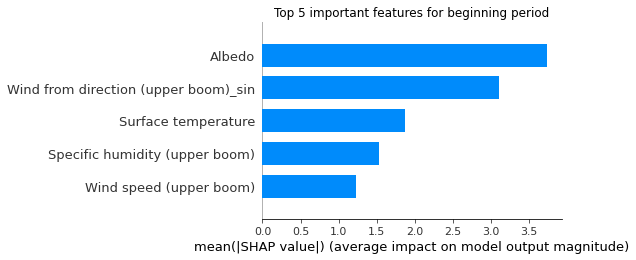

R^2 score on test set (middle):  0.7239112179859688
MSE on test set (middle):  32.61315061680491
Top 5 important features for middle period:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Wind from direction (upper boom)_sin    3.341060
Albedo                                  2.215878
Surface temperature                     2.113502
Specific humidity (upper boom)          2.072901
Air temperature (upper boom)            0.977840
dtype: float32

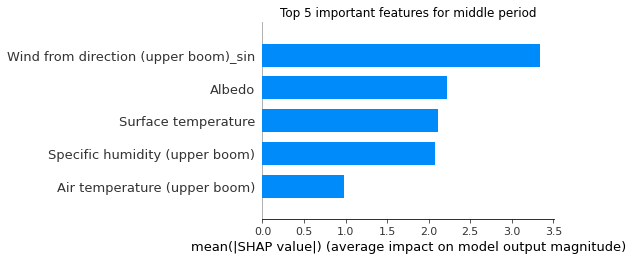

R^2 score on test set (end):  0.5742403581174045
MSE on test set (end):  57.40327620278414
Top 5 important features for end period:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Albedo                                         3.614805
Wind from direction (upper boom)_sin           2.978678
Surface temperature                            1.764070
Specific humidity (upper boom)                 1.704508
Downwelling shortwave radiation - corrected    1.481610
dtype: float32

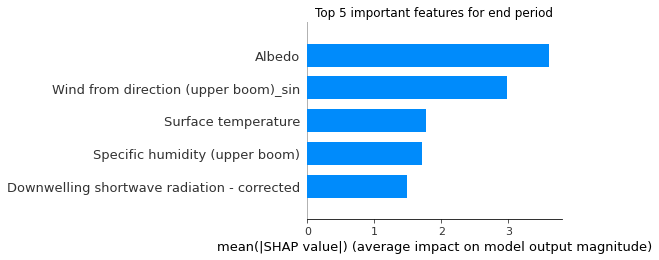

In [115]:
### This bit for absolute
import pandas as pd
import numpy as np

for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_absolute_train.index)
    y_Train_valid_indices = indices.intersection(y_absolute_train.index)
    X_Test_valid_indices = indices.intersection(X_absolute_test.index)
    y_Test_valid_indices = indices.intersection(y_absolute_test.index)

    # filter out by indeces
    X_train_category = X_absolute_train.loc[X_Train_valid_indices]
    y_train_category = y_absolute_train.loc[y_Train_valid_indices]
    X_test_category = X_absolute_test.loc[X_Test_valid_indices]
    y_test_category = y_absolute_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    #model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_absolute.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)
    
    explainer = shap.TreeExplainer(model_absolute)
    shap_values = explainer.shap_values(X_test_category, approximate=True)
    
    # Display top 5 features and SHAP values
    feature_importances = pd.Series(abs(shap_values).mean(0), index=X_test_category.columns)
    top_features = feature_importances.nlargest(5)
    shap_values_top = [shap_values[i] for i in np.where(feature_importances.index.isin(top_features.index))[0]]
    df_shap = pd.DataFrame(np.transpose(shap_values_top), columns=top_features.index)
    print(f"Top 5 important features for {category} period:")
    display(top_features)
    
    shap.summary_plot(shap_values, X_test_category, plot_type="bar", feature_names=X_test_category.columns, max_display=5, show=False)
    plt.title(f"Top 5 important features for {category} period")
    plt.show()


-----------

## LSTM

In [313]:
# This bit to find best LSTM model for when Ablation == True and for both target variables

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Impute missing values
    X_train_category = X_train_category.fillna(X_train_category.mean())
    y_train_category = y_train_category.fillna(y_train_category.mean())
    X_test_category = X_test_category.fillna(X_test_category.mean())

    
    # Reshape the input data to 3D array
    X_train_category = X_train_category.values.reshape((X_train_category.shape[0], 1, X_train_category.shape[1]))
    X_test_category = X_test_category.values.reshape((X_test_category.shape[0], 1, X_test_category.shape[1]))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_category.shape[2])))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the training data
    model.fit(X_train_category, y_train_category, epochs=50, batch_size=64, validation_data=(X_test_category, y_test_category), verbose=0)
    
    # Evaluate the model on the test set
    y_pred_category = model.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)


R^2 score on test set (delta):  -0.10340557736615308
MSE on test set (delta):  0.0038937158256251167
R^2 score on test set (absolute):  0.013685247670754519
MSE on test set (absolute):  157.86584193346172


--------